In [ ]:
!pip install efficientnet_pytorch


  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16031 sha256=d1b284d4187f258c0f05b91fe11915e3c53f8561914797fc0f5e53550e9e5064
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import argparse
import os
import re

import cv2
import numpy as np
import torch
from skimage import io
from torch import nn
from torchvision import models

import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
def get_net(net_name, weight_path=None):
    """
    根据网络名称获取模型
    :param net_name: 网络名称
    :param weight_path: 与训练权重路径
    :return:
    """
    pretrain = weight_path is None 
    if net_name in ['vgg', 'vgg16']:
        net = models.vgg16(pretrained=pretrain)
    elif net_name == 'vgg19':
        net = models.vgg19(pretrained=pretrain)
    elif net_name in ['resnet', 'resnet50']:
        net = models.resnet50(pretrained=pretrain)
    elif net_name == 'resnet101':
        net = models.resnet101(pretrained=pretrain)
    elif net_name in ['densenet', 'densenet121']:
        net = models.densenet121(pretrained=pretrain)
    elif net_name in ['inception']:
        net = models.inception_v3(pretrained=pretrain)
    elif net_name in ['mobilenet_v2']:
        net = models.mobilenet_v2(pretrained=pretrain)
    elif net_name in ['shufflenet_v2']:
        net = models.shufflenet_v2_x1_0(pretrained=pretrain)
    else:
        raise ValueError('invalid network name:{}'.format(net_name))
    # 加载指定路径的权重参数
    if weight_path is not None and net_name.startswith('densenet'):
        pattern = re.compile(
            r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')
        state_dict = torch.load(weight_path)
        for key in list(state_dict.keys()):
            res = pattern.match(key)
            if res:
                new_key = res.group(1) + res.group(2)
                state_dict[new_key] = state_dict[key]
                del state_dict[key]
        net.load_state_dict(state_dict)
    elif weight_path is not None:
        net.load_state_dict(torch.load(weight_path))
    return net


def get_last_conv_name(model):
    layer_name = None
    for name, m in model.named_modules():
        if isinstance(m, nn.Conv2d):
            layer_name = name
    return layer_name


def prepare_input(img):
    # img = io.imread(IMG_PATH)
    # img = np.float32(cv2.resize(img, (224, 224))) / 255
    image = img.copy()
    means = np.array([0.485, 0.456, 0.406])
    stds = np.array([0.229, 0.224, 0.225])
    image -= means
    image /= stds

    image = np.ascontiguousarray(np.transpose(image, (2, 0, 1)))  # channel first
    image = image[np.newaxis, ...]  # 增加batch维

    return torch.tensor(image, requires_grad=True)

def gen_cam(image, mask):
    """
    生成CAM图
    :param image: [H,W,C],原始图像
    :param mask: [H,W],范围0~1
    :return: tuple(cam,heatmap)
    """
    # mask转为heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap[..., ::-1]  # gbr to rgb

    # 合并heatmap到原始图像
    cam = heatmap + np.float32(image)
    return norm_image(cam), (heatmap * 255).astype(np.uint8)


def norm_image(image):
    """
    标准化图像
    :param image: [H,W,C]
    :return:
    """
    image = image.copy()
    image -= np.max(np.min(image), 0)
    image /= np.max(image)
    image *= 255.
    return np.uint8(image)


def gen_gb(grad):
    """
    生guided back propagation 输入图像的梯度
    :param grad: tensor,[3,H,W]
    :return:
    """
    # 标准化
    grad = grad.data.numpy()
    gb = np.transpose(grad, (1, 2, 0))
    return gb


def save_image(image_dicts, input_image_name, network, output_dir):
    prefix = os.path.splitext(input_image_name)[0]
    for key, image in image_dicts.items():
        io.imsave(os.path.join(output_dir, '{}-{}-{}.jpg'.format(prefix, network, key)), image)


In [ ]:
def grad_cam(model, class_id , layer_name, input):
    feature = None
    gradient = None
    model.eval()
    handlers = []

    def _get_features_hook(module, input, output):
        nonlocal feature
        print(feature)
        feature = output

    def _get_grads_hook(module, input_grad, output_grad):
        nonlocal gradient
        gradient = output_grad[0]

    for (name, module) in model.named_modules():
        if name == layer_name:
            handlers.append(module.register_forward_hook(_get_features_hook))
            handlers.append(module.register_backward_hook(_get_grads_hook))
    model.zero_grad()
    output = model(inputs)  # [1,num_classes]
    soft = nn.Softmax(dim = 1)
    confidence = soft(output)

    print(output.size())
    if class_id is None:
        index = np.argmax(output.cpu().data.numpy())
    else:
        index = class_id
    
    target = output[0][index]
    print(target)
    target.backward()

    grads = gradient[0].cpu().data.numpy()  # [K,H,W]
    a_k = np.mean(grads, axis=(1, 2))  # [K]
    A_i_j_k = feature[0].cpu().data.numpy()  # [K,H,W]

    L_c = A_i_j_k * a_k[:, np.newaxis, np.newaxis]  # [K,H,W]
    L_c = np.sum(L_c, axis=0)  # [H,W]
    L_c = np.maximum(L_c, 0)  # ReLU

    # normalize
    L_c -= np.min(L_c)
    L_c /= np.max(L_c)
    # resize to 224*224
    L_c = cv2.resize(L_c, (224, 224))

    print("len(hendlers)", len(handlers))
    for handle in handlers:
        handle.remove()
    return L_c

In [ ]:
def grad_cam_plusplus(model, class_id , layer_name, input):
    feature = None
    gradient = None
    model.eval()
    handlers = []

    def _get_features_hook(module, input, output):
        nonlocal feature
        feature = output
        print("feature shape:{}".format(output.size()))

    def _get_grads_hook(module, input_grad, output_grad):
        nonlocal gradient
        gradient = output_grad[0]
        print("gradient shape:{}".format(gradient.size()))

    for (name, module) in model.named_modules():
        if name == layer_name:
            handlers.append(module.register_forward_hook(_get_features_hook))
            handlers.append(module.register_backward_hook(_get_grads_hook))
    
    model.zero_grad()
    output = model(inputs)  # [1,num_classes]

    if class_id is None:
        index = np.argmax(output.cpu().data.numpy())
    else:
      index = class_id
    
    target = output[0][index]

    target.backward()

    model.zero_grad()
    output = model(inputs)  # [1,num_classes]
    if index is None:
        index = np.argmax(output.cpu().data.numpy())
    target = output[0][index]
    target.backward()

    gradient = gradient[0].cpu().data.numpy()  # [C,H,W]
    gradient = np.maximum(gradient, 0.)  # ReLU
    indicate = np.where(gradient > 0, 1., 0.)  # 示性函数
    norm_factor = np.sum(gradient, axis=(1, 2))  # [C]归一化
    for i in range(len(norm_factor)):
        norm_factor[i] = 1. / norm_factor[i] if norm_factor[i] > 0. else 0.  # 避免除零
    alpha = indicate * norm_factor[:, np.newaxis, np.newaxis]  # [C,H,W]

    weight = np.sum(gradient * alpha, axis=(1, 2))  # [C]  alpha*ReLU(gradient)

    feature = feature[0].cpu().data.numpy()  # [C,H,W]

    cam = feature * weight[:, np.newaxis, np.newaxis]  # [C,H,W]
    cam = np.sum(cam, axis=0)  # [H,W]
    # cam = np.maximum(cam, 0)  # ReLU

    # 数值归一化
    cam -= np.min(cam)
    cam /= np.max(cam)
    # resize to 224*224
    cam = cv2.resize(cam, (224, 224))
    return cam

features.denseblock4.denselayer16.conv2
None
torch.Size([1, 1000])
tensor(9.6327, grad_fn=<SelectBackward>)
len(hendlers) 2
(224, 224)


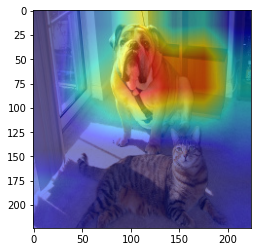

In [ ]:
import copy
IMG_PATH = f'/content/drive/My Drive/ADDL/20201027161028.JPEG'
# IMG_PATH = f'/content/drive/My Drive/input/cams/pic1.jpg'

img = io.imread(IMG_PATH)
img = np.float32(cv2.resize(img, (224, 224))) / 255
inputs = prepare_input(img)
# 网络
model = get_net("densenet121")
# Grad-CAM
layer_name = get_last_conv_name(model)
print(layer_name)
mask = grad_cam(model, None, layer_name = layer_name, input = input) # cam mask

print(mask.shape)
E_c, _ = gen_cam(img, mask)

imgplot = plt.imshow(E_c)
# E_c = copy.deepcopy(img)
# print(E_c.shape)
# for i in range(3):
#   E_c[:,:,i] = np.multiply(mask,E_c[:,:,i])

# imgplot = plt.imshow(E_c)
# E_c = norm_image(E_c)
io.imsave("/content/drive/My Drive/ADDL/example.JPEG", E_c)

In [ ]:
import copy
IMG_PATH = f'/content/drive/My Drive/input/cams/ILSVRC2012_val_00000198_E_c.JPEG'
img = io.imread(IMG_PATH)
img = np.float32(cv2.resize(img, (224, 224))) / 255
inputs = prepare_input(img)
# 网络
model = get_net("densenet121")
# Grad-CAM
layer_name = get_last_conv_name(model)
print(layer_name)
mask = grad_cam(model, None, layer_name = layer_name, input = input) # cam mask


features.denseblock4.denselayer16.conv2
torch.Size([1, 1000])
tensor(0.2679, grad_fn=<SelectBackward>)
140235091490712
[<torch.utils.hooks.RemovableHandle object at 0x7f8b076aaba8>, <torch.utils.hooks.RemovableHandle object at 0x7f8b06cee470>]


In [ ]:
image_dict['cam'], image_dict['heatmap'] = gen_cam(img, mask)

# imgplot = plt.imshow(image_dict['cam'])

In [ ]:
img = io.imread(IMG_PATH)
img = np.float32(cv2.resize(img, (224, 224))) / 255
inputs = prepare_input(img)
# 输出图像
image_dict = {}
# 网络
net = get_net("densenet121")
# Grad-CAM
layer_name = get_last_conv_name(net)
print(layer_name)
grad_cam = GradCAM(net, layer_name)
mask = grad_cam(inputs)  # cam mask
image_dict['cam'], image_dict['heatmap'] = gen_cam(img, mask)
grad_cam.remove_handlers()

# Grad-CAM++
# grad_cam_plus_plus = GradCamPlusPlus(net, layer_name)
# mask_plus_plus = grad_cam_plus_plus(inputs, args.class_id)  # cam mask
# image_dict['cam++'], image_dict['heatmap++'] = gen_cam(img, mask_plus_plus)
# grad_cam_plus_plus.remove_handlers()

# # GuidedBackPropagation
# gbp = GuidedBackPropagation(net)
# inputs.grad.zero_()  # 梯度置零
# grad = gbp(inputs)

# gb = gen_gb(grad)
# image_dict['gb'] = norm_image(gb)
# # 生成Guided Grad-CAM
# cam_gb = gb * mask[..., np.newaxis]
# image_dict['cam_gb'] = norm_image(cam_gb)

# save_image(image_dict, os.path.basename(args.image_path), args.network, args.output_dir)

features.denseblock4.denselayer16.conv2
feature shape:torch.Size([1, 32, 7, 7])


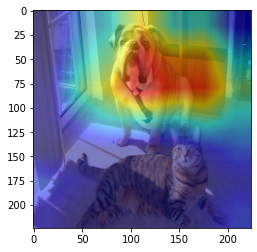

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
imgplot = plt.imshow(image_dict['cam'])